# Calibration and Fusion

Python script from https://gitlab.eurecom.fr/nautsch/pybosaris/tree/master. Python implementation of BOSARIS toolkit https://sites.google.com/site/bosaristoolkit/. The script is based on `linear_calibrate_scores.m`, `train_linear_calibration.m` and `train_binary_classifier.m` from the BOSARIS Matlab toolkit.

**Ressources**

* [The BOSARIS Toolkit: Theory, Algorithms and
Code for Surviving the New DCF](https://arxiv.org/pdf/1304.2865.pdf)
* [The BOSARIS Toolkit User Guide: Theory, Algorithms and Code for Binary Classifier Score Processing](https://docs.google.com/viewer?a=v&pid=sites&srcid=ZGVmYXVsdGRvbWFpbnxib3NhcmlzdG9vbGtpdHxneDozOTEwZjAzZmM3ZThmNjE0)

In [1]:
from unittest import TestCase
import os
import sys
lib_path = os.path.join(os.path.dirname('.'), "pybosaris-master")
sys.path.append(lib_path)
from pybosaris.calibration.linear_fuser import LinearFuser
from pybosaris.calibration.objectives import evaluate_objective
from pybosaris.calibration.training import train_binary_classifier
from pybosaris.libperformance import cllr, min_cllr
from operator import itemgetter
from sklearn.metrics import roc_curve
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
%matplotlib inline

## 1. Preprocess training data

In [2]:
# Split data in target and non-target trials
scores = pd.read_pickle('snorm.pkl')
tar = np.array(scores[scores.label == 1]['normalized_score'])
non = np.array(scores[scores.label == 0]['normalized_score'])

# Instantiate a LinearFuser
# Function handle for function that must be trained
# Get a starting point for the calibration weights: 'w0',
# which are zeros by default
train_scores = np.hstack((tar, non))
fuser = LinearFuser(scores=train_scores)

# Create label vector
# Let the trainer know which scores are target scores and which are non-target scores. 
ntar = tar.shape[0]
nnon = non.shape[0]
classf = np.hstack((np.ones(ntar), -np.ones(nnon)))

## 2. Train linear classifier

Do the training to get the calibration weights 'w'

In [3]:
# Taken from `/misc/scratch05/patx/alamja/sre19works/fusion_stuffs/scripts_for_calibration_fusion/fusion_sre19_cmn2_CRIM_v0.m`
prior = 0.005
maxiters = 50
quiet = False
objfun = None
w0 = fuser.w
w, train_cxe, w_pen, optimizerState, converged = train_binary_classifier(
    classifier=fuser, classf=classf, w0=w0,
    objective_function=objfun, prior=prior,
    penalizer=None, penalizer_weight=0,
    maxiters=maxiters, maxCG=100, optimizerState=None, quiet=quiet, cstepHessian=True)
print(f'Scaling: {w[0]}, Offset: {w[1]}')
train_cxe, w_pen, optimizerState, converged

2019-10-07 14:56:22.042 INFO     TR 0 (initial state): obj = 1, Delta = 0.647677
2019-10-07 14:56:22.138 INFO     CG 0: curv=0.07444935268185317, terminate on trust region boundary, model=0.03664747403944974
2019-10-07 14:56:22.161 INFO     expanding: Delta=1.29535
2019-10-07 14:56:22.161 INFO     TR 1: obj=0.963359; rho=0.999814
2019-10-07 14:56:22.238 INFO     CG 0: curv=0.07748602275021839, terminate on trust region boundary, model=0.14889439128035864
2019-10-07 14:56:22.259 INFO     expanding: Delta=2.59071
2019-10-07 14:56:22.260 INFO     TR 2: obj=0.815314; rho=0.994299
2019-10-07 14:56:22.338 INFO     CG 0: curv=0.101449, radius = 0.740379, residual=2.90786, model=0.555754
2019-10-07 14:56:22.420 INFO     CG 1: curv=0.00428085, converged inside trust region; radius = 0.967355, residual=2.58922e-15, model=0.649921
2019-10-07 14:56:22.461 INFO     contracting: Delta=0.647677
2019-10-07 14:56:22.462 INFO     TR 3: obj=0.815314; backtracking; rho=-0.991775
2019-10-07 14:56:22.463 IN

Scaling: 2.393525419459394, Offset: -4.4368493636149795


(0.33101142702519526,
 0,
 {'Delta': 2.590708691577784,
  'y': 0.33101142702519526,
  'g': array([5.87507415e-06, 5.39215219e-06]),
  'hess': functools.partial(<bound method ReplaceHessian.hessian of <pybosaris.calibration.objectives.ReplaceHessian object at 0x1175bcf28>>, dy=1, w=array([ 2.39352542, -4.43684936]))},
 False)

## 3. Calibrate input scores

Create a function handle that will calibrate input scores using the trained weights: 'w'.

In [4]:
train_fuser = LinearFuser(scores=train_scores, w=w)
train_fused_scores = train_fuser.fusion()
train_c = cllr(train_fused_scores[:ntar], train_fused_scores[ntar:])
train_c_min = min_cllr(train_fused_scores[:ntar], train_fused_scores[ntar:])
logging.info('train Cxe = {}, cllr: {}, min: {}'.format(train_cxe, train_c, train_c_min))
train_fuser
train_fused_scores
train_c
train_c_min

2019-10-07 14:56:37.815 INFO     train Cxe = 0.33101142702519526, cllr: 0.2499196944247855, min: 0.24396251646720607


array([13.41495912,  4.57981211,  2.72846791, ..., -3.7404842 ,
       -5.7557267 , -6.19155452])

0.2499196944247855

0.24396251646720607

## 4. Analysis

In [5]:
def calculate_eer(y, y_score, pos):
# y denotes groundtruth scores,
# y_score denotes the prediction scores.

    fpr, tpr, thresholds = roc_curve(y, y_score, pos_label=pos)
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    thresh = interp1d(fpr, thresholds)(eer)

    return eer, thresh, fpr, tpr

# Creates a list of false-negative rates, a list of false-positive rates
# and a list of decision thresholds that give those error-rates.
def ComputeErrorRates(scores, labels):

    # Sort the scores from smallest to largest, and also get the corresponding
    # indexes of the sorted scores.  We will treat the sorted scores as the
    # thresholds at which the the error-rates are evaluated.
    sorted_indexes, thresholds = zip(*sorted(
        [(index, threshold) for index, threshold in enumerate(scores)],
        key=itemgetter(1)))
    sorted_labels = []
    labels = [labels[i] for i in sorted_indexes]
    fnrs = []
    fprs = []

    # At the end of this loop, fnrs[i] is the number of errors made by
    # incorrectly rejecting scores less than thresholds[i]. And, fprs[i]
    # is the total number of times that we have correctly accepted scores
    # greater than thresholds[i].
    for i in range(0, len(labels)):
        if i == 0:
            fnrs.append(labels[i])
            fprs.append(1 - labels[i])
        else:
            fnrs.append(fnrs[i-1] + labels[i])
            fprs.append(fprs[i-1] + 1 - labels[i])
    fnrs_norm = sum(labels)
    fprs_norm = len(labels) - fnrs_norm

    # Now divide by the total number of false negative errors to
    # obtain the false positive rates across all thresholds
    fnrs = [x / float(fnrs_norm) for x in fnrs]

    # Divide by the total number of corret positives to get the
    # true positive rate.  Subtract these quantities from 1 to
    # get the false positive rates.
    fprs = [1 - x / float(fprs_norm) for x in fprs]
    return fnrs, fprs, thresholds

# Computes the minimum of the detection cost function.  The comments refer to
# equations in Section 3 of the NIST 2016 Speaker Recognition Evaluation Plan.
def ComputeMinDcf(fnrs, fprs, thresholds, p_target, c_miss, c_fa):
    min_c_det = float("inf")
    min_c_det_threshold = thresholds[0]
    for i in range(0, len(fnrs)):
        # See Equation (2).  it is a weighted sum of false negative
        # and false positive errors.
        c_det = c_miss * fnrs[i] * p_target + c_fa * fprs[i] * (1 - p_target)
        if c_det < min_c_det:
            min_c_det = c_det
            min_c_det_threshold = thresholds[i]
    # See Equations (3) and (4).  Now we normalize the cost.
    c_def = min(c_miss * p_target, c_fa * (1 - p_target))
    min_dcf = min_c_det / c_def
    return min_dcf, min_c_det_threshold

def compute_actual_cost(scores, labels, p_target, c_miss=1, c_fa=1):
    beta = c_fa * (1 - p_target) / (c_miss * p_target)
    decisions = (scores >= np.log(beta)).astype('i')
    num_targets = np.sum(labels)
    fp = np.sum(decisions * (1 - labels))
    num_nontargets = np.sum(1 - labels)
    fn = np.sum((1 - decisions) * labels)
    fpr = fp / num_nontargets if num_nontargets > 0 else np.nan
    fnr = fn / num_targets if num_targets > 0 else np.nan
    print("act_C : {0:.4f}, at threshold {1:.4f} (p-target={2}, c-miss={3}, "
    "c-fa={4})".format(fnr + beta * fpr, np.log(beta), p_target, c_miss, c_fa))
    return fnr + beta * fpr, np.log(beta), fpr, fnr

### 4.1 Calibrated

In [6]:
eer, thresh, fpr, tpr = calculate_eer(classf, train_fused_scores, pos=1)
print('EER : %.2f%%'%(eer*100))

EER : 6.97%


In [7]:
c_miss = 1
c_fa = 1
p_target = 0.05
classf[classf == -1] = 0

fnrs, fprs, thresholds = ComputeErrorRates(train_fused_scores, 
                                           classf)
mindcf, threshold = ComputeMinDcf(fnrs, fprs, thresholds, p_target, c_miss, c_fa)

print("minDCF : {0:.4f}, at threshold {1:.4f} (p-target={2}, c-miss={3}, "
    "c-fa={4})".format(mindcf, threshold, p_target,c_miss, c_fa))

minDCF : 0.3346, at threshold 3.0452 (p-target=0.05, c-miss=1, c-fa=1)


In [8]:
C_norm1, thresh1, fpr, fnr = compute_actual_cost(train_fused_scores, classf, 0.01)
C_norm2, thresh2, fpr, fnr = compute_actual_cost(train_fused_scores, classf, 0.005)
C_primary = (C_norm1 + C_norm2) / 2
print("C_primary : {0:.4f}".format(C_primary))

act_C : 0.4695, at threshold 4.5951 (p-target=0.01, c-miss=1, c-fa=1)
act_C : 0.5279, at threshold 5.2933 (p-target=0.005, c-miss=1, c-fa=1)
C_primary : 0.4987


### 4.2 Uncalibrated

In [9]:
eer, thresh, fpr, tpr = calculate_eer(classf, train_scores, pos=1)
print('EER : %.2f%%'%(eer*100))

EER : 6.97%


In [10]:
c_miss = 1
c_fa = 1
p_target = 0.05
classf[classf == -1] = 0

fnrs, fprs, thresholds = ComputeErrorRates(train_scores, 
                                           classf)
mindcf, threshold_un = ComputeMinDcf(fnrs, fprs, thresholds, p_target, c_miss, c_fa)

print("minDCF : {0:.4f}, at threshold {1:.4f} (p-target={2}, c-miss={3}, "
    "c-fa={4})".format(mindcf, threshold_un, p_target,c_miss, c_fa))

minDCF : 0.3346, at threshold 3.1260 (p-target=0.05, c-miss=1, c-fa=1)


In [11]:
C_norm1, thresh1_un, fpr, fnr = compute_actual_cost(train_scores, classf, 0.01)
C_norm2, thresh2_un, fpr, fnr = compute_actual_cost(train_scores, classf, 0.005)
C_primary = (C_norm1 + C_norm2) / 2
print("C_primary : {0:.4f}".format(C_primary))

act_C : 0.5991, at threshold 4.5951 (p-target=0.01, c-miss=1, c-fa=1)
act_C : 0.7549, at threshold 5.2933 (p-target=0.005, c-miss=1, c-fa=1)
C_primary : 0.6770


### 4.3 Plot

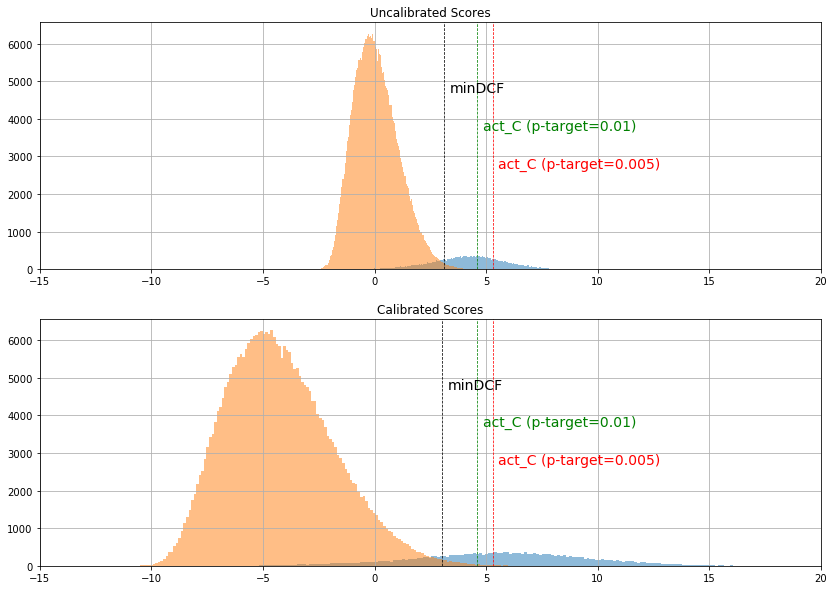

In [12]:
plt.figure(figsize=(14,10),)
fig = plt.subplot(211)
plt.hist(train_scores[:ntar], bins=200, alpha=0.5,)
plt.hist(train_scores[ntar:], bins=200, alpha=0.5,)
plt.text(threshold_un+0.25, 5000, 'minDCF', fontsize=14,verticalalignment='top')
plt.text(thresh1_un+0.25, 4000, 'act_C (p-target=0.01)', c='green', fontsize=14, verticalalignment='top')
plt.text(thresh2_un+0.25, 3000, 'act_C (p-target=0.005)', c='red', fontsize=14, verticalalignment='top')
plt.axvline(x=threshold_un, c='black', linestyle='--', lw=0.75, label='minDCF: '+str(np.round(threshold,4)))
plt.axvline(x=thresh1_un, c='green', linestyle='--', lw=0.75, label='act_C (p-target=0.01): '+str(np.round(thresh1,4)))
plt.axvline(x=thresh2_un, c='red', linestyle='--', lw=0.75, label='act_C (p-target=0.005): '+str(np.round(thresh2,4)))
plt.title('Uncalibrated Scores')
plt.grid()
plt.xlim(-15,20);

fig = plt.subplot(212)
plt.hist(train_fused_scores[:ntar], bins=200, alpha=0.5,)
plt.hist(train_fused_scores[ntar:], bins=200, alpha=0.5,)
plt.text(threshold+0.25, 5000, 'minDCF', fontsize=14, verticalalignment='top')
plt.text(thresh1+0.25, 4000, 'act_C (p-target=0.01)', c='green', fontsize=14, verticalalignment='top')
plt.text(thresh2+0.25, 3000, 'act_C (p-target=0.005)', c='red', fontsize=14, verticalalignment='top')
plt.axvline(x=threshold, c='black', linestyle='--', lw=0.75, label='minDCF: '+str(np.round(threshold,4)))
plt.axvline(x=thresh1, c='green', linestyle='--', lw=0.75, label='act_C (p-target=0.01): '+str(np.round(thresh1,4)))
plt.axvline(x=thresh2, c='red', linestyle='--', lw=0.75, label='act_C (p-target=0.005): '+str(np.round(thresh2,4)))
plt.title('Calibrated Scores')
plt.grid()
# plt.legend()
plt.xlim(-15,20);

## 5. System Fusing

### 5.1 Preprocess training data

In [13]:
# Split data in target and non-target trials
ztscores = pd.read_pickle('asnorm.pkl')
zttar = np.array(ztscores[ztscores.label == 1]['normalized_score'])
ztnon = np.array(ztscores[ztscores.label == 0]['normalized_score'])

# Instantiate a LinearFuser
# Function handle for function that must be trained
# Get a starting point for the calibration weights: 'w0',
# which are zeros by default
zttrain_scores = np.hstack((zttar, ztnon))
ztfuser = LinearFuser(scores=zttrain_scores)

# Create label vector
# Let the trainer know which scores are target scores and which are non-target scores. 
ztntar = zttar.shape[0]
ztnnon = ztnon.shape[0]
ztclassf = np.hstack((np.ones(ztntar), -np.ones(ztnnon)))

### 5.2 Train linear classifier

Do the training to get the calibration weights 'w'

In [14]:
ztprior = 0.1
ztmaxiters = 50
ztquiet = False
ztobjfun = None
ztw0 = ztfuser.w
ztw, zttrain_cxe, ztw_pen, ztoptimizerState, ztconverged = train_binary_classifier(
    classifier=ztfuser, classf=ztclassf, w0=ztw0,
    objective_function=ztobjfun, prior=ztprior,
    penalizer=None, penalizer_weight=0,
    maxiters=ztmaxiters, maxCG=100, optimizerState=None, quiet=ztquiet, cstepHessian=True)
print(f'Scaling: {w[0]}, Offset: {w[1]}')
zttrain_cxe, ztw_pen, ztoptimizerState, ztconverged

2019-10-07 14:56:43.700 INFO     TR 0 (initial state): obj = 1, Delta = 1.95568
2019-10-07 14:56:43.780 INFO     CG 0: curv=11.933, radius = 0.320512, residual=1.49924, model=0.612926
2019-10-07 14:56:43.845 INFO     CG 1: curv=0.0177715, converged inside trust region; radius = 0.842743, residual=8.38462e-15, model=0.820854
2019-10-07 14:56:43.863 INFO     TR 1: obj=0.486138; rho=0.626009
2019-10-07 14:56:43.941 INFO     CG 0: curv=0.0458514, radius = 0.343847, residual=6.79369, model=0.105431
2019-10-07 14:56:44.015 INFO     CG 1: curv=0.0178497, converged inside trust region; radius = 0.59977, residual=2.86989e-14, model=0.163123
2019-10-07 14:56:44.033 INFO     TR 2: obj=0.300429; rho=1.13846
2019-10-07 14:56:44.119 INFO     CG 0: curv=0.0134612, radius = 0.124816, residual=4.56055, model=0.0181449
2019-10-07 14:56:44.191 INFO     CG 1: curv=0.000785632, converged inside trust region; radius = 0.297292, residual=1.02788e-14, model=0.0315938
2019-10-07 14:56:44.208 INFO     TR 3: obj

Scaling: 2.393525419459394, Offset: -4.4368493636149795


(0.2519588166241414,
 0,
 {'Delta': 1.9556755853819663,
  'y': 0.2519588166241414,
  'g': array([1.18584613e-20, 1.69406589e-21]),
  'hess': functools.partial(<bound method ReplaceHessian.hessian of <pybosaris.calibration.objectives.ReplaceHessian object at 0x106cb6128>>, dy=1, w=array([ 1.3117091, -0.8228296]))},
 True)

### 5.3 Calibrate input scores

Create a function handle that will calibrate input scores using the trained weights: 'w'.

In [15]:
zttrain_fuser = LinearFuser(scores=zttrain_scores, w=ztw)
zttrain_fused_scores = zttrain_fuser.fusion()
zttrain_c = cllr(zttrain_fused_scores[:ntar], zttrain_fused_scores[ntar:])
zttrain_c_min = min_cllr(zttrain_fused_scores[:ztntar], zttrain_fused_scores[ztntar:])
logging.info('train Cxe = {}, cllr: {}, min: {}'.format(zttrain_cxe, zttrain_c, zttrain_c_min))
zttrain_fuser
zttrain_fused_scores
zttrain_c
zttrain_c_min

2019-10-07 14:56:49.997 INFO     train Cxe = 0.2519588166241414, cllr: 0.2421815727512532, min: 0.24015156200997065


array([14.29322226,  5.58601139,  3.49514761, ..., -3.5205527 ,
       -6.05974736, -6.49822879])

0.2421815727512532

0.24015156200997065

### 5.4 Analysis

In [16]:
eer, thresh, fpr, tpr = calculate_eer(ztclassf, zttrain_fused_scores, pos=1)
print('EER : %.2f%%'%(eer*100))

EER : 6.85%


In [17]:
c_miss = 1
c_fa = 1
p_target = 0.05
ztclassf[ztclassf == -1] = 0

fnrs, fprs, thresholds = ComputeErrorRates(zttrain_fused_scores, 
                                           ztclassf)
mindcf, threshold = ComputeMinDcf(fnrs, fprs, thresholds, p_target, c_miss, c_fa)

print("minDCF : {0:.4f}, at threshold {1:.4f} (p-target={2}, c-miss={3}, "
    "c-fa={4})".format(mindcf, threshold, p_target,c_miss, c_fa))

minDCF : 0.3423, at threshold 2.8607 (p-target=0.05, c-miss=1, c-fa=1)


In [18]:
C_norm1, thresh1, fpr, fnr = compute_actual_cost(zttrain_fused_scores, ztclassf, 0.01)
C_norm2, thresh2, fpr, fnr = compute_actual_cost(zttrain_fused_scores, ztclassf, 0.005)
C_primary = (C_norm1 + C_norm2) / 2
print("C_primary : {0:.4f}".format(C_primary))

act_C : 0.4981, at threshold 4.5951 (p-target=0.01, c-miss=1, c-fa=1)
act_C : 0.5683, at threshold 5.2933 (p-target=0.005, c-miss=1, c-fa=1)
C_primary : 0.5332


### 5.5 Merge scores

In [19]:
# Divide scores of each system to target and non-target
tar = train_fused_scores[classf==1]
non = train_fused_scores[classf==0]
zttar = zttrain_fused_scores[ztclassf==1]
ztnon = zttrain_fused_scores[ztclassf==0]

# Merge target and non-target instances of each system
# Merge to single scores array
tar = np.vstack((tar, zttar))
non = np.vstack((non, ztnon))
merged_train_scores = np.vstack((tar.T, non.T)).T

# Instantiate Fuser
merged_fuser = LinearFuser(scores=merged_train_scores)

# Labels
ntar = tar.shape[1]
nnon = non.shape[1]
merged_classf = np.hstack((np.ones(ntar), -np.ones(nnon)))

### 5.6 Train Linear Classifier

In [20]:
prior = 0.1
maxiters = 50
quiet = False
objfun = None
w0 = merged_fuser.w
w, train_cxe, w_pen, optimizerState, converged = train_binary_classifier(
    classifier=merged_fuser, classf=merged_classf, w0=w0,
    objective_function=objfun, prior=prior,
    penalizer=None, penalizer_weight=0,
    maxiters=maxiters, maxCG=100, optimizerState=None, quiet=quiet, cstepHessian=True)
# print(f'Scaling: {w[0]}, Offset: {w[1]}')
train_cxe, w_pen, optimizerState, converged

2019-10-07 14:56:52.344 INFO     TR 0 (initial state): obj = 1, Delta = 3.73569
2019-10-07 14:56:52.468 INFO     CG 0: curv=190.157, converged inside trust region; radius = 0.0733887, residual=0.904888, model=0.512084
2019-10-07 14:56:52.487 INFO     TR 1: obj=0.390221; rho=1.19078
2019-10-07 14:56:52.568 INFO     CG 0: curv=6.38526, converged inside trust region; radius = 0.0450285, residual=0.277363, model=0.086134
2019-10-07 14:56:52.589 INFO     TR 2: obj=0.283428; rho=1.23985
2019-10-07 14:56:52.670 INFO     CG 0: curv=0.297323, converged inside trust region; radius = 0.0375053, residual=0.224627, model=0.0242846
2019-10-07 14:56:52.691 INFO     TR 3: obj=0.25424; rho=1.20189
2019-10-07 14:56:52.782 INFO     CG 0: curv=0.0120229, converged inside trust region; radius = 0.0212794, residual=0.155766, model=0.00391515
2019-10-07 14:56:52.799 INFO     TR 4: obj=0.249904; rho=1.10772
2019-10-07 14:56:52.881 INFO     CG 0: curv=0.000207454, converged inside trust region; radius = 0.0046

(0.2497548186565158,
 0,
 {'Delta': 3.7356925978352744,
  'y': 0.2497548186565158,
  'g': array([-6.14710272e-08,  6.74887145e-08, -8.59177545e-09]),
  'hess': functools.partial(<bound method ReplaceHessian.hessian of <pybosaris.calibration.objectives.ReplaceHessian object at 0x119f34ef0>>, dy=1, w=array([0.46177758, 0.49901578, 0.03769804]))},
 True)

### 5.7 Calibrate input scores

In [21]:
merged_train_fuser = LinearFuser(scores=merged_train_scores, w=w)
merged_train_fused_scores = merged_train_fuser.fusion()
train_c = cllr(merged_train_fused_scores[:ntar], merged_train_fused_scores[ntar:])
train_c_min = min_cllr(merged_train_fused_scores[:ntar], merged_train_fused_scores[ntar:])
logging.info('train Cxe = {}, cllr: {}, min: {}'.format(train_cxe, train_c, train_c_min))
merged_train_fuser
merged_train_fused_scores
train_c
train_c_min

2019-10-07 14:56:58.630 INFO     train Cxe = 0.2497548186565158, cllr: 0.24277501388462586, min: 0.2401986386661346


array([13.36496877,  4.94006039,  3.04177714, ..., -3.44638503,
       -5.64407702, -6.06414169])

0.24277501388462586

0.2401986386661346

### 5.8 Analysis

In [22]:
eer, thresh, fpr, tpr = calculate_eer(merged_classf, merged_train_fused_scores, pos=1)
print('EER : %.2f%%'%(eer*100))

EER : 6.88%


In [23]:
c_miss = 1
c_fa = 1
p_target = 0.05
merged_classf[merged_classf == -1] = 0

fnrs, fprs, thresholds = ComputeErrorRates(merged_train_fused_scores, 
                                           merged_classf)
mindcf, threshold = ComputeMinDcf(fnrs, fprs, thresholds, p_target, c_miss, c_fa)

print("minDCF : {0:.4f}, at threshold {1:.4f} (p-target={2}, c-miss={3}, "
    "c-fa={4})".format(mindcf, threshold, p_target,c_miss, c_fa))

minDCF : 0.3363, at threshold 2.7879 (p-target=0.05, c-miss=1, c-fa=1)


In [24]:
C_norm1, thresh1, fpr, fnr = compute_actual_cost(merged_train_fused_scores, merged_classf, 0.01)
C_norm2, thresh2, fpr, fnr = compute_actual_cost(merged_train_fused_scores, merged_classf, 0.005)
C_primary = (C_norm1 + C_norm2) / 2
print("C_primary : {0:.4f}".format(C_primary))

act_C : 0.4749, at threshold 4.5951 (p-target=0.01, c-miss=1, c-fa=1)
act_C : 0.5444, at threshold 5.2933 (p-target=0.005, c-miss=1, c-fa=1)
C_primary : 0.5096


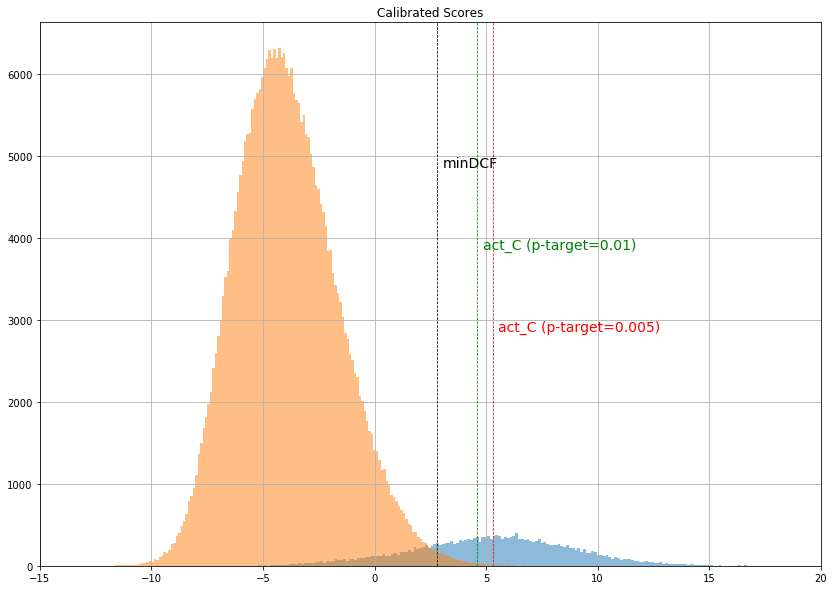

In [25]:
plt.figure(figsize=(14,10),)
fig = plt.subplot(111)
plt.hist(merged_train_fused_scores[:ntar], bins=200, alpha=0.5,)
plt.hist(merged_train_fused_scores[ntar:], bins=200, alpha=0.5,)
plt.text(threshold+0.25, 5000, 'minDCF', fontsize=14, verticalalignment='top')
plt.text(thresh1+0.25, 4000, 'act_C (p-target=0.01)', c='green', fontsize=14, verticalalignment='top')
plt.text(thresh2+0.25, 3000, 'act_C (p-target=0.005)', c='red', fontsize=14, verticalalignment='top')
plt.axvline(x=threshold, c='black', linestyle='--', lw=0.75, label='minDCF: '+str(np.round(threshold,4)))
plt.axvline(x=thresh1, c='green', linestyle='--', lw=0.75, label='act_C (p-target=0.01): '+str(np.round(thresh1,4)))
plt.axvline(x=thresh2, c='red', linestyle='--', lw=0.75, label='act_C (p-target=0.005): '+str(np.round(thresh2,4)))
plt.title('Calibrated Scores')
plt.grid()
# plt.legend()
plt.xlim(-15,20);